# Loan Default Prediction Project - Workflow

This notebook follows a professional end-to-end workflow for a loan default prediction project, including data exploration, preprocessing, modeling, and deployment.

---



## 1- Import libraries


In [4]:
# 1. Standard Libraries & Configuration
import warnings
import pickle
import joblib
import numpy as np
import pandas as pd

# Filter warnings
warnings.filterwarnings('ignore')


# 2. Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: Set default style
sns.set_style("whitegrid")


# 3. Preprocessing & Pipeline Construction
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Imbalanced Learning Pipeline (Crucial for handling SMOTE inside pipelines)
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE


# 4. Machine Learning Models
# Linear & SVM

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Tree-Based & Ensembles
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

# Boosting (External Libraries)
from xgboost import XGBClassifier


# 5. Metrics & Evaluation
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    roc_auc_score, 
    roc_curve, 
    confusion_matrix, 
    classification_report, 
    balanced_accuracy_score
)

## 2- Load & Explore Data
- In this section, we load the dataset into a Pandas DataFrame and begin exploring its structure.  
The goal is to understand what the data looks like **before** performing any cleaning or modeling.


In [ ]:
df = pd.read_csv(r"Data/Loan_default.csv")


print(df.shape) # rows = 255347 , columns = 18
print(int(df.memory_usage(deep=True).sum() / 1024 ** 2) , "MB") # memory usage = 126 MB
display(df.columns.tolist())


(255347, 18)
126 MB


['LoanID',
 'Age',
 'Income',
 'LoanAmount',
 'CreditScore',
 'MonthsEmployed',
 'NumCreditLines',
 'InterestRate',
 'LoanTerm',
 'DTIRatio',
 'Education',
 'EmploymentType',
 'MaritalStatus',
 'HasMortgage',
 'HasDependents',
 'LoanPurpose',
 'HasCoSigner',
 'Default']

In [6]:
display(df.head())
display(df.tail())

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,No,No,Business,No,0
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0


,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
255342,8C6S86ESGC,19,37979,210682,541,109,4,14.11,12,0.85,Bachelor's,Full-time,Married,No,No,Other,No,0
255343,98R4KDHNND,32,51953,189899,511,14,2,11.55,24,0.21,High School,Part-time,Divorced,No,No,Home,No,1
255344,XQK1UUUNGP,56,84820,208294,597,70,3,5.29,60,0.50,High School,Self-employed,Married,Yes,Yes,Auto,Yes,0
255345,JAO28CPL4H,42,85109,60575,809,40,1,20.90,48,0.44,High School,Part-time,Single,Yes,Yes,Other,No,0
255346,ZTH91CGL0B,62,22418,18481,636,113,2,6.73,12,0.48,Bachelor's,Unemployed,Divorced,Yes,No,Education,Yes,0


In [7]:
df.info() # no missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255347 entries, 0 to 255346
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   LoanID          255347 non-null  object 
 1   Age             255347 non-null  int64  
 2   Income          255347 non-null  int64  
 3   LoanAmount      255347 non-null  int64  
 4   CreditScore     255347 non-null  int64  
 5   MonthsEmployed  255347 non-null  int64  
 6   NumCreditLines  255347 non-null  int64  
 7   InterestRate    255347 non-null  float64
 8   LoanTerm        255347 non-null  int64  
 9   DTIRatio        255347 non-null  float64
 10  Education       255347 non-null  object 
 11  EmploymentType  255347 non-null  object 
 12  MaritalStatus   255347 non-null  object 
 13  HasMortgage     255347 non-null  object 
 14  HasDependents   255347 non-null  object 
 15  LoanPurpose     255347 non-null  object 
 16  HasCoSigner     255347 non-null  object 
 17  Default   

In [8]:
display(df.describe().T)

,count,mean,std,min,25%,50%,75%,max
Age,255347.0,43.498306,14.990258,18.0,31.00,43.00,56.00,69.0
Income,255347.0,82499.304597,38963.013729,15000.0,48825.50,82466.00,116219.00,149999.0
LoanAmount,255347.0,127578.865512,70840.706142,5000.0,66156.00,127556.00,188985.00,249999.0
CreditScore,255347.0,574.264346,158.903867,300.0,437.00,574.00,712.00,849.0
MonthsEmployed,255347.0,59.541976,34.643376,0.0,30.00,60.00,90.00,119.0
NumCreditLines,255347.0,2.501036,1.117018,1.0,2.00,2.00,3.00,4.0
InterestRate,255347.0,13.492773,6.636443,2.0,7.77,13.46,19.25,25.0
LoanTerm,255347.0,36.025894,16.969330,12.0,24.00,36.00,48.00,60.0
DTIRatio,255347.0,0.500212,0.230917,0.1,0.30,0.50,0.70,0.9
Default,255347.0,0.116128,0.320379,0.0,0.00,0.00,0.00,1.0


In [9]:
df.drop(columns=["LoanID"], inplace=True) # dropping LoanID as it is just an identifier

print(df.isna().sum())
print(df.duplicated().sum())

Age               0
Income            0
LoanAmount        0
CreditScore       0
MonthsEmployed    0
NumCreditLines    0
InterestRate      0
LoanTerm          0
DTIRatio          0
Education         0
EmploymentType    0
MaritalStatus     0
HasMortgage       0
HasDependents     0
LoanPurpose       0
HasCoSigner       0
Default           0
dtype: int64
0


## Summary of Step: Loading & Exploring the Data

In this step, we loaded the loan dataset and explored its structure, contents, and basic statistics.

**Key information obtained:**

- **Number of rows:** 255,347  
- **Number of columns:** 18  
- **Memory usage:** ~126 MB (using `deep=True`)  
- **Column names:**  
  `['LoanID', 'Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed', 'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio', 'Education', 'EmploymentType', 'MaritalStatus', 'HasMortgage', 'HasDependents', 'LoanPurpose', 'HasCoSigner', 'Default']`  
- **Dropped column:** LoanID (identifier)  
- **Missing values:** None  
- **Duplicated rows:** None  
- **Data types:** Mix of numeric and categorical features  

**Summary statistics (key numeric features):**

- Age: min 18, max 69, mean ~43  
- Income: min 15,000, max 149,999, mean ~82,499  
- LoanAmount: min 5,000, max 249,999, mean ~127,578  
- CreditScore: min 300, max 849, mean ~574  
- MonthsEmployed: min 0, max 119, mean ~59  
- InterestRate: min 2, max 25, mean ~13.5  
- DTIRatio: min 0.1, max 0.9, mean ~0.50  
- Default: mean ~0.116 (11.6% of loans defaulted, dataset is imbalanced)  

This step gives us a clear understanding of the dataset before proceeding to cleaning, feature engineering, and modeling.


## 2- Cleaning & Type Conversion
- In this section, we clean the dataset by handling missing values, converting data types.

In [ ]:

categorical_cols = ['Education', 'EmploymentType', 'MaritalStatus', 
                    'HasMortgage', 'HasDependents', 'LoanPurpose', 'HasCoSigner']

# Convert to category
df[categorical_cols] = df[categorical_cols].astype('category')

# Check updated types
df.dtypes


Age                  int64
Income               int64
LoanAmount           int64
CreditScore          int64
MonthsEmployed       int64
NumCreditLines       int64
InterestRate       float64
LoanTerm             int64
DTIRatio           float64
Education         category
EmploymentType    category
MaritalStatus     category
HasMortgage       category
HasDependents     category
LoanPurpose       category
HasCoSigner       category
Default              int64
dtype: object

In [11]:
print(df.isna().sum())
print(df.duplicated().sum())

Age               0
Income            0
LoanAmount        0
CreditScore       0
MonthsEmployed    0
NumCreditLines    0
InterestRate      0
LoanTerm          0
DTIRatio          0
Education         0
EmploymentType    0
MaritalStatus     0
HasMortgage       0
HasDependents     0
LoanPurpose       0
HasCoSigner       0
Default           0
dtype: int64
0


- ### Outlier Detection

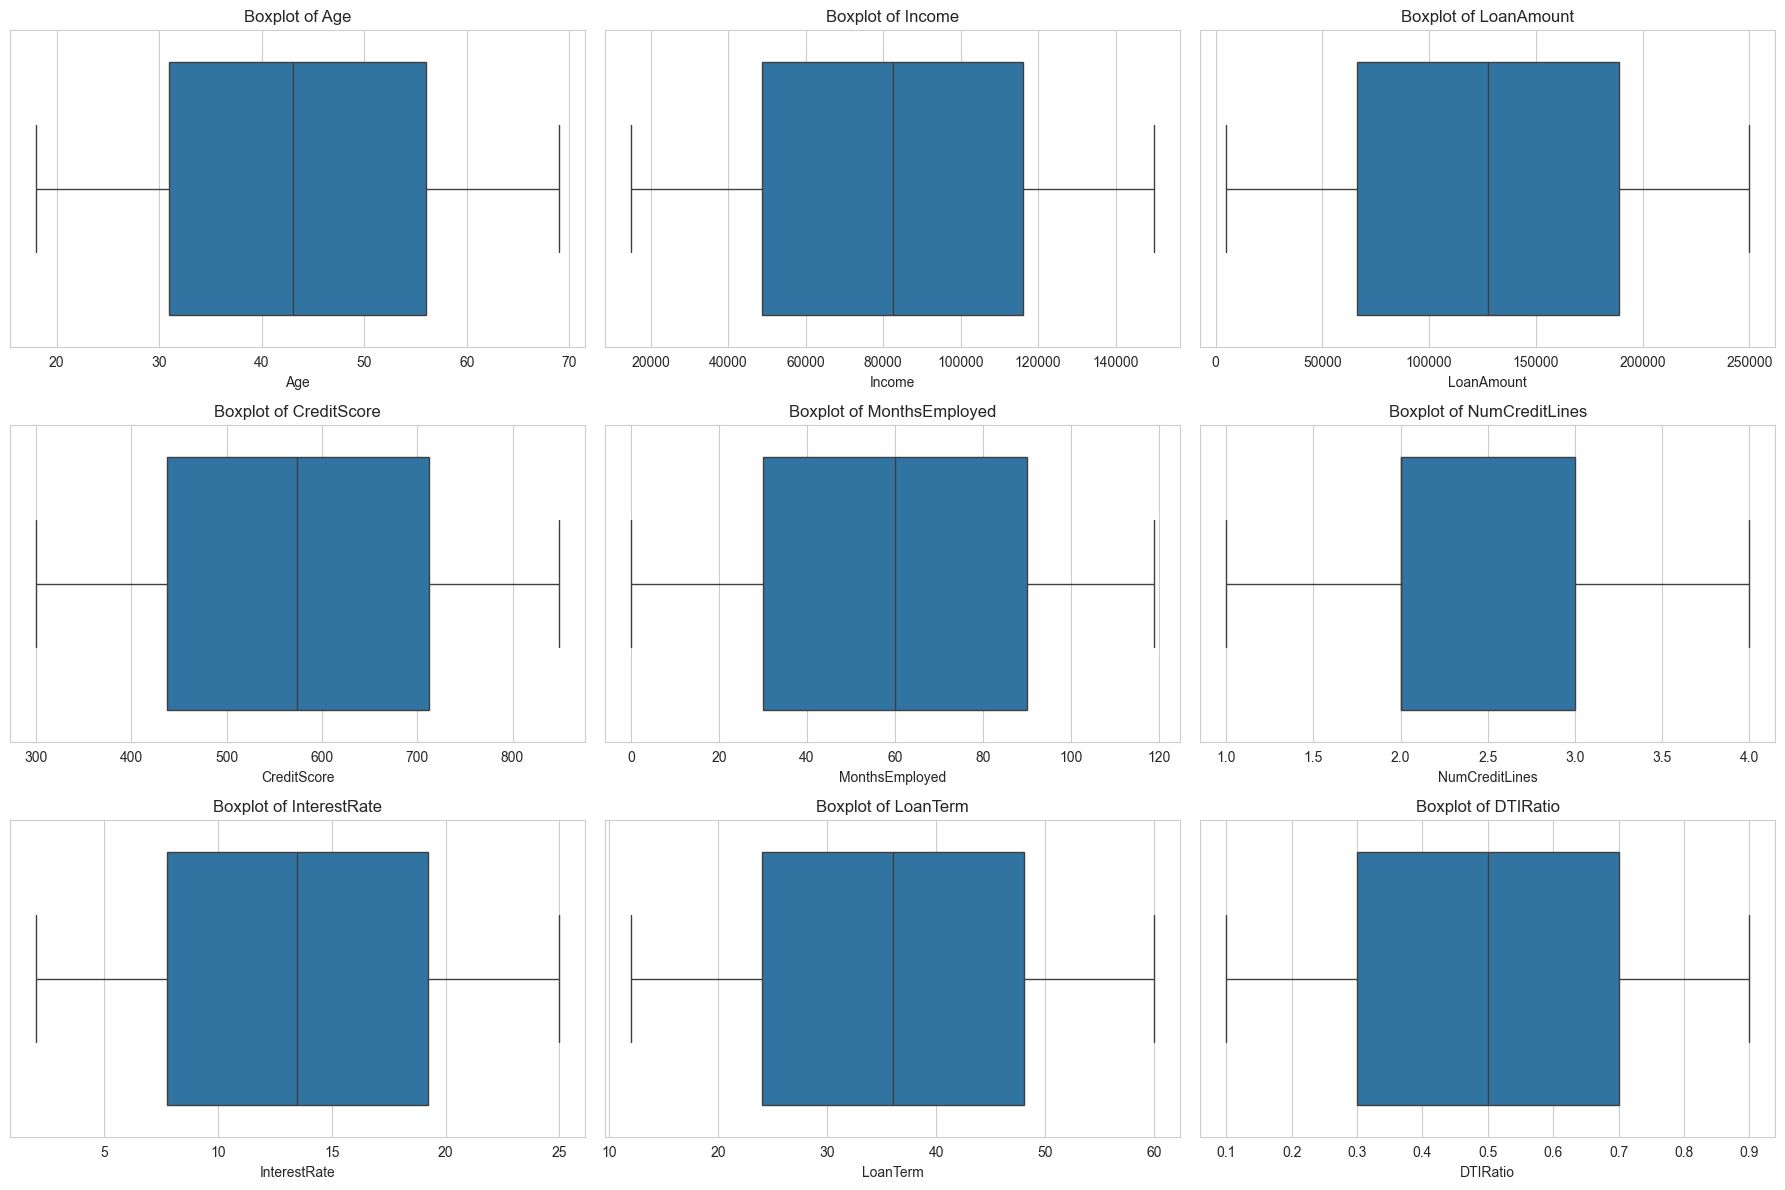

In [ ]:
numeric_cols = ['Age', 'Income', 'LoanAmount', 'CreditScore', 
                'MonthsEmployed', 'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio']

# Create boxplots
plt.figure(figsize=(18, 12))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()


In [13]:

print(int(df.memory_usage(deep=True).sum() / 1024 ** 2) , "MB") # memory usage = 21 MB

21 MB


## Summary of Step: Data Cleaning & Type Conversion

In this step, we prepared the dataset for modeling by ensuring correct types and checking for data quality issues.

**Key points:**

- Checked for missing values and duplicate rows — **none found**.  
- Numeric features (`Age`, `Income`, `LoanAmount`, `CreditScore`, `MonthsEmployed`, `NumCreditLines`, `InterestRate`, `LoanTerm`, `DTIRatio`, `Default`) are correctly typed.  
- Converted categorical features to `category` type for memory efficiency and easier preprocessing:  
  `Education`, `EmploymentType`, `MaritalStatus`, `HasMortgage`, `HasDependents`, `LoanPurpose`, `HasCoSigner`.  
- Visual inspection with boxplots showed **no outliers** in numeric features.
- Memory usage after type conversion is approximately 25 MB.

The dataset is now clean and properly typed, ready for feature engineering and preprocessing.


## 3- Step: Feature Engineering

- In this step, we create new features and transform existing ones to improve the predictive power of our models. Feature engineering helps the model better capture patterns in the data and ensures that categorical and numeric features are ready for preprocessing.



**1- Loan-to-Income Ratio**

In [14]:
df['Loan_to_Income'] = df['LoanAmount'] / df['Income']

**2- Employment Stability**

In [15]:
df['Employment_Stability'] = df['MonthsEmployed'] / 12


**3- Credit Lines per Year of Employment**

In [16]:
df['CreditLines_per_Year'] = df['NumCreditLines'] / (df['Employment_Stability'] + 0.1)

**4- High-Risk Loan Flag**

In [17]:
df['High_Risk_Loan'] = ((df['DTIRatio'] > 0.6) | (df['CreditScore'] < 500)).astype(int)

In [18]:
df.to_csv("loan_data_After_feature_engineering.csv", index=False)

print(df.shape) # rows = 255347  , columns = 21
print(int(df.memory_usage(deep=True).sum() / 1024 ** 2) , "MB") # memory usage = 28 MB

(255347, 21)
28 MB


## Summary of Step: Feature Engineering

In this step, we created new features and prepared the dataset for modeling to improve predictive performance. Feature engineering helps the model better capture patterns in the data and ensures numeric and categorical features are organized for preprocessing.

**New Features Added:**

1. **Loan_to_Income** – Ratio of loan amount to income.  
   *Helps assess if the borrower can afford the loan; lower values indicate easier repayment.*

2. **Employment_Stability** – Months employed converted to years.  
   *Measures work stability, which indicates a reliable source of income.*

3. **CreditLines_per_Year** – Number of credit lines divided by years of employment (+0.1 to avoid division by zero).  
   *Shows financial exposure relative to work experience; higher values may indicate higher risk.*

4. **High_Risk_Loan** – Binary flag (1 if DTI ratio > 0.6 or Credit Score < 500, else 0).  
   *Highlights high-risk borrowers explicitly for the model.*

**Column Preparation:**

- **Numeric features:** `Age`, `Income`, `LoanAmount`, `CreditScore`, `MonthsEmployed`, `NumCreditLines`, `InterestRate`, `LoanTerm`, `DTIRatio`, `Loan_to_Income`, `Employment_Stability`, `CreditLines_per_Year`, `High_Risk_Loan`  
- **Categorical features:** `Education`, `EmploymentType`, `MaritalStatus`, `HasMortgage`, `HasDependents`, `LoanPurpose`, `HasCoSigner`  

**Notes:**

- All features were retained because they are relevant to predicting loan default.  
- Categorical features are still readable for EDA; encoding will be done later in the pipeline.  
- Dataset is now ready for **Exploratory Data Analysis (EDA)**.


## 4- Step: Exploratory Data Analysis (EDA)

In this step, we explore the dataset to understand the distributions, relationships, and patterns within the data. EDA helps identify trends, potential correlations, imbalances, and insights that can guide feature selection and preprocessing for modeling.

**Key activities:**

- Visualize **numeric features** using histograms, boxplots, and density plots to understand distributions and detect any skewness.  
- Explore **categorical features** using bar plots to examine frequency distributions.  
- Analyze the **relationship between features and the target variable (`Default`)** to identify strong predictors.  
- Check **correlations** between numeric features and the target, as well as among features themselves.  

EDA provides a clear understanding of the dataset and informs preprocessing and model-building decisions.


### 1- Distribution of Numeric Features

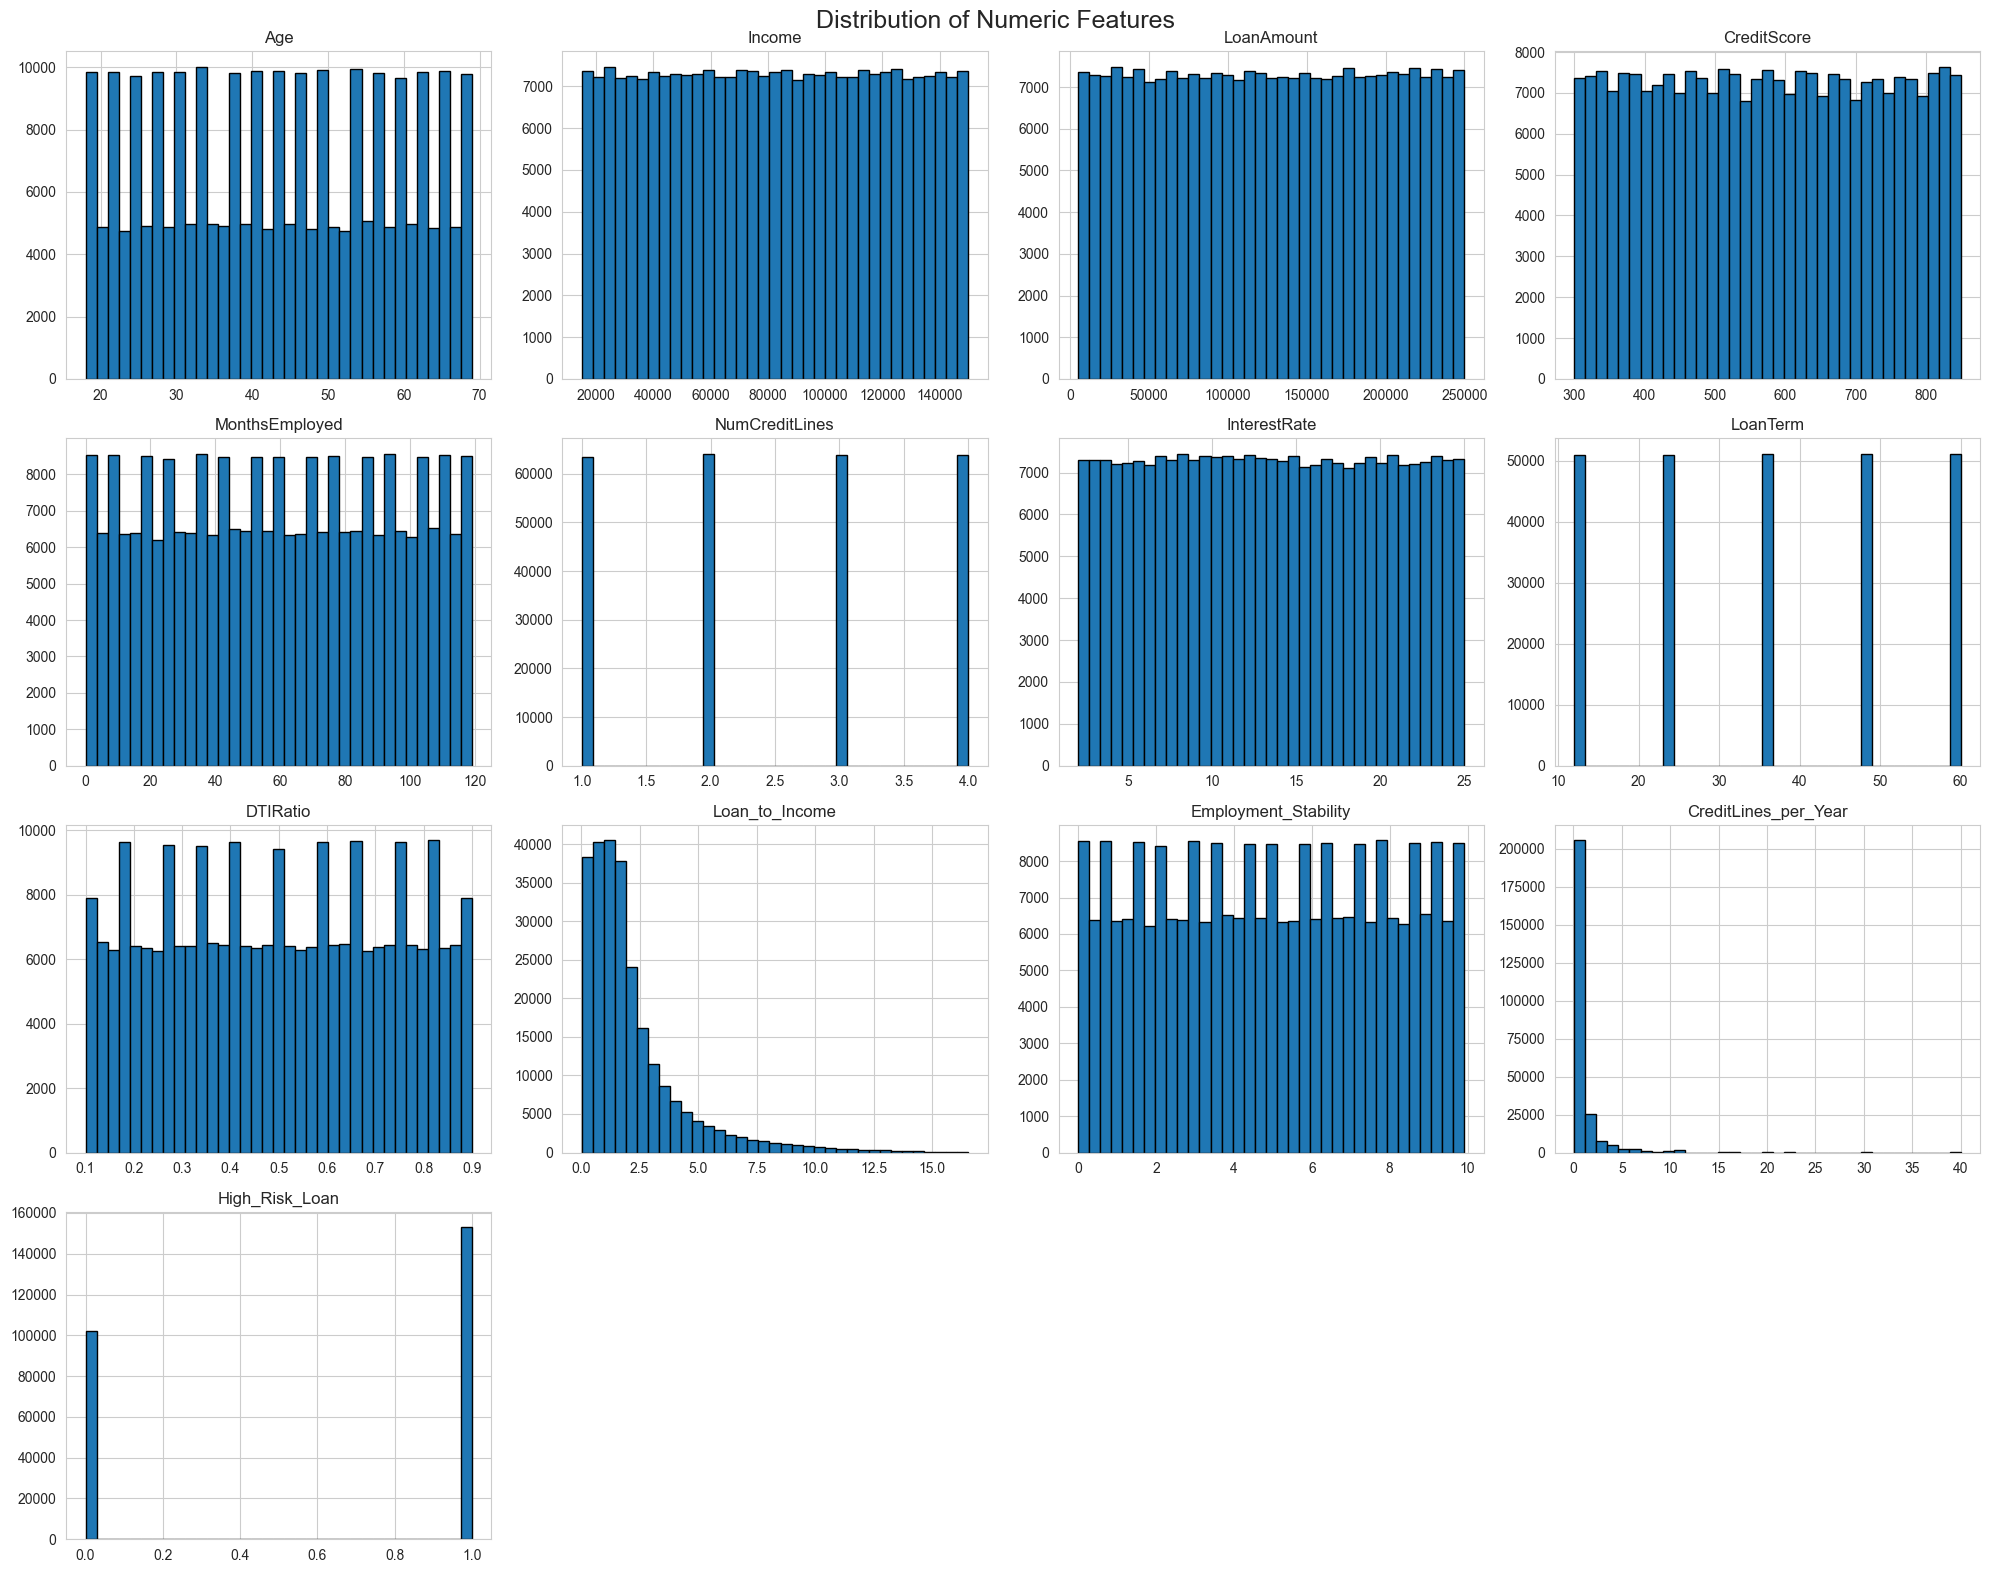

In [19]:
numeric_cols = ['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed',
                'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio',
                'Loan_to_Income', 'Employment_Stability', 'CreditLines_per_Year', 
                'High_Risk_Loan']

df[numeric_cols].hist(figsize=(20, 16), bins=35, edgecolor='black')
plt.suptitle("Distribution of Numeric Features", fontsize=18)
plt.tight_layout()
plt.show()


### 2-Count Plots for Categorical Features

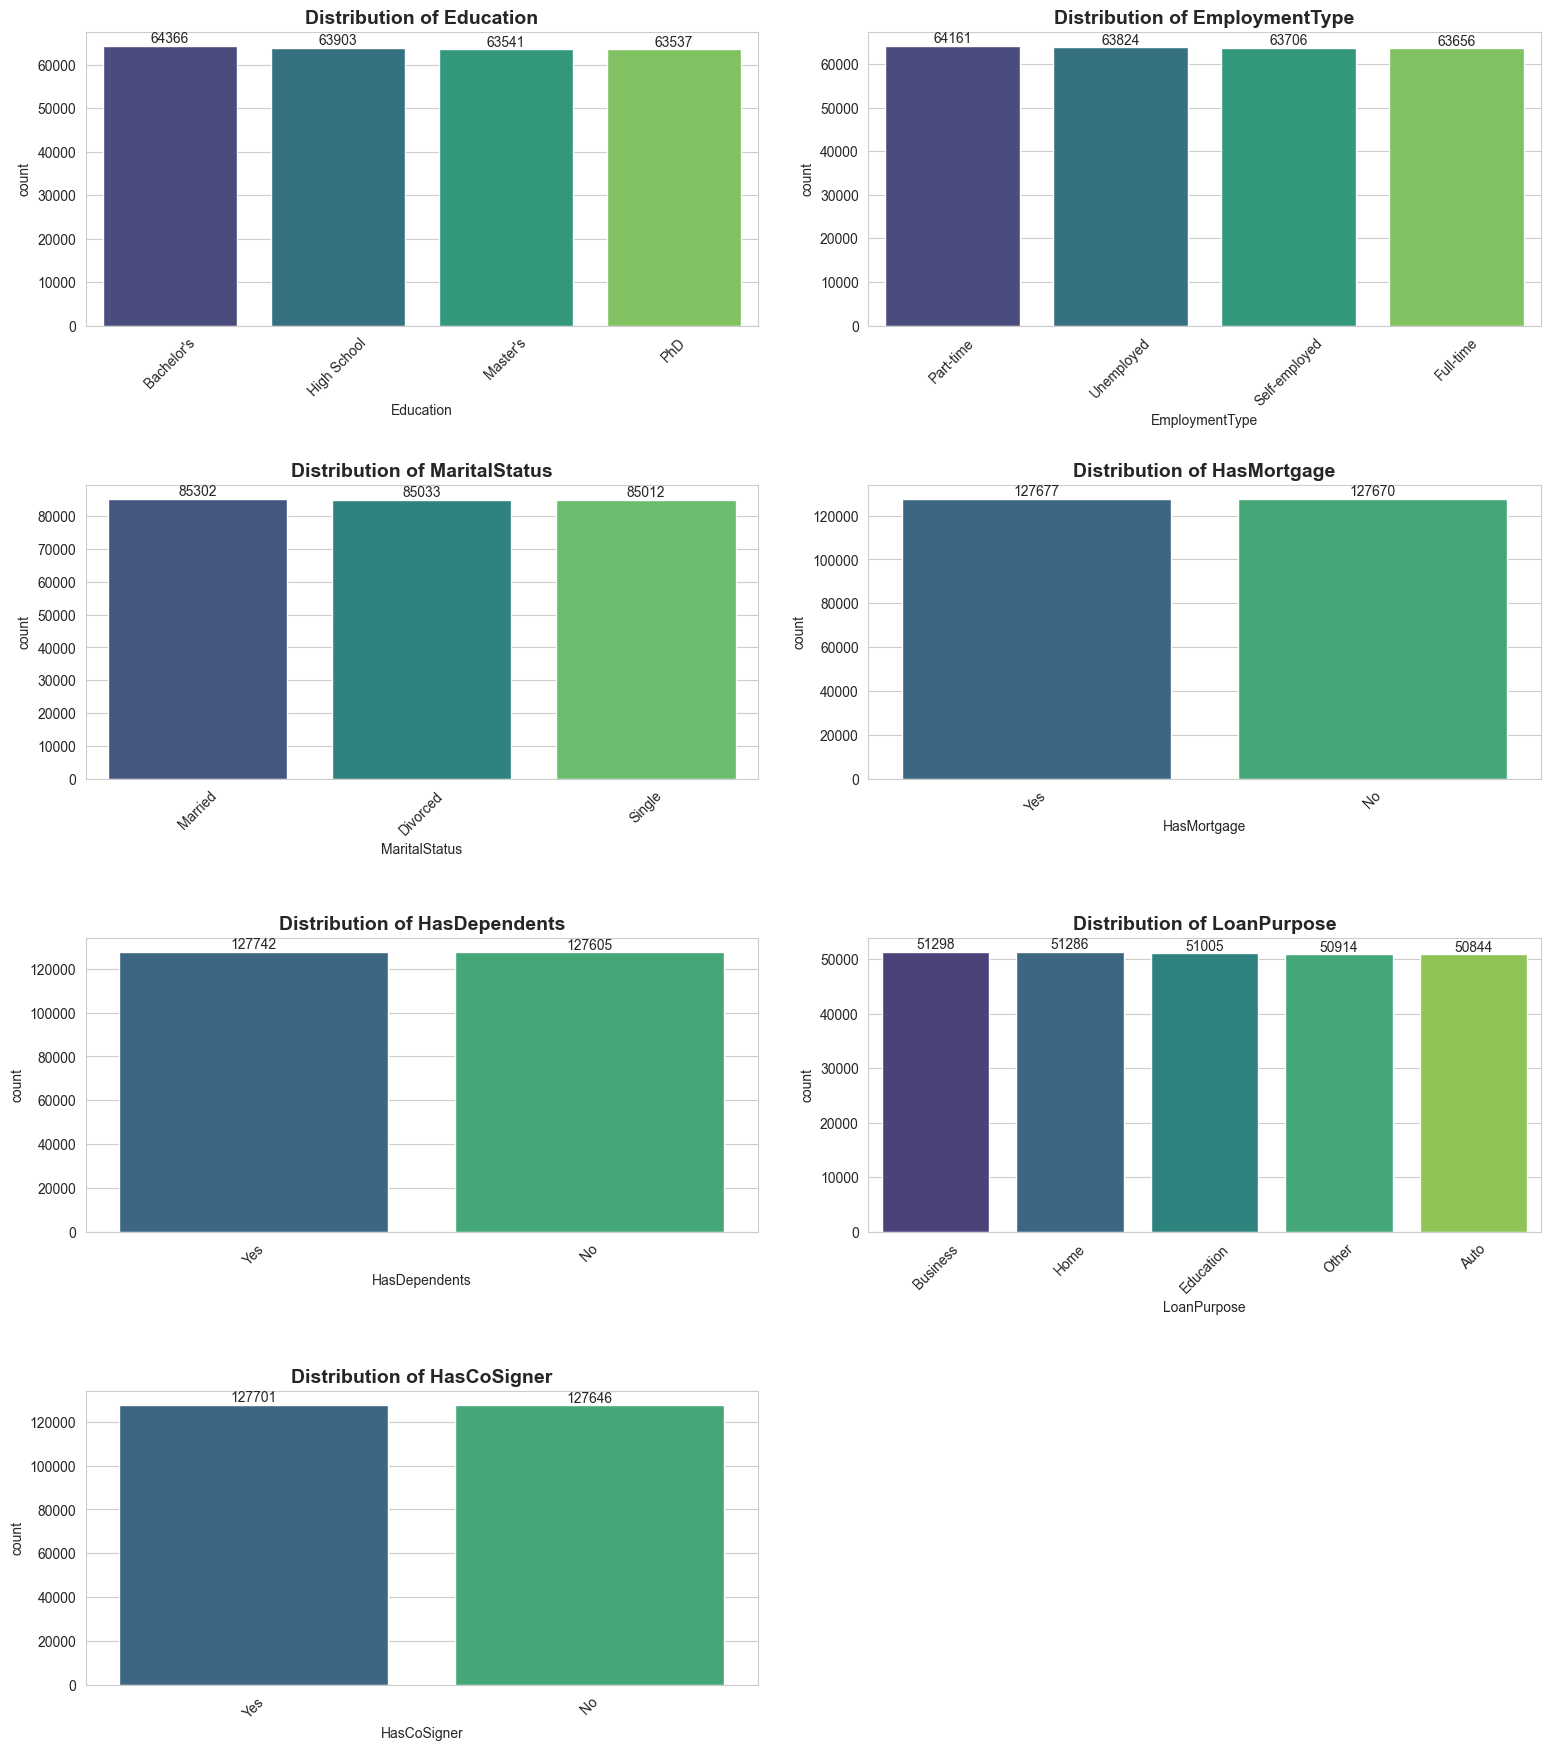

In [20]:
categorical_cols = [
    'Education', 'EmploymentType', 'MaritalStatus',
    'HasMortgage', 'HasDependents', 'LoanPurpose', 'HasCoSigner'
]

# Set up subplot grid
fig, axes = plt.subplots(4, 2, figsize=(16, 18))
axes = axes.flatten()

for ax, col in zip(axes, categorical_cols):
    sns.countplot(
        data=df, 
        x=col, 
        ax=ax,
        palette='viridis',
        order=df[col].value_counts().index
    )
    
    ax.set_title(f"Distribution of {col}", fontsize=14, fontweight='bold')
    ax.tick_params(axis='x', rotation=45)
    
    # Add count labels
    for patch in ax.patches:
        height = patch.get_height()
        ax.text(
            patch.get_x() + patch.get_width()/2,
            height,
            f'{int(height)}',
            ha='center',
            va='bottom',
            fontsize=10
        )

# Remove empty subplots
for empty_ax in axes[len(categorical_cols):]:
    fig.delaxes(empty_ax)

plt.tight_layout(pad=2.5)
plt.show()


### 3- Default Class Distribution

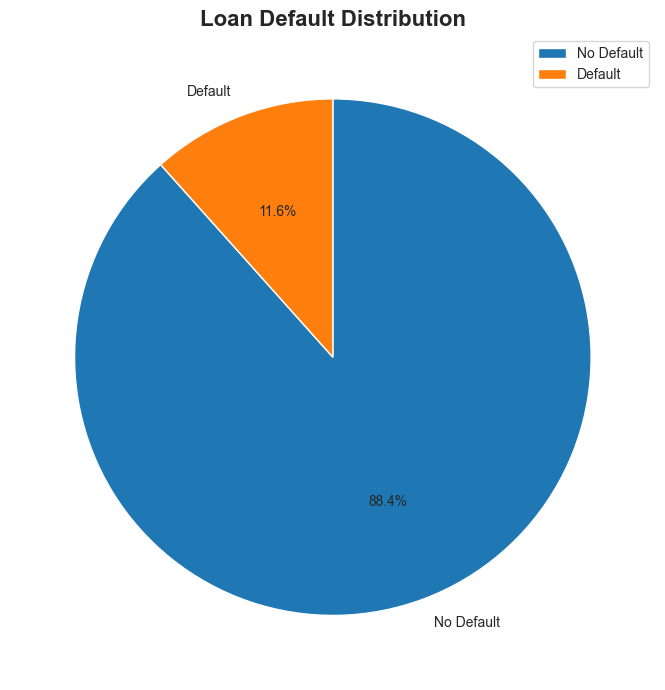

In [ ]:
default_counts = df['Default'].value_counts()

plt.figure(figsize=(7, 7))

plt.pie(
    default_counts,
    labels=default_counts.index.map({0: "No Default", 1: "Default"}),
    autopct='%1.1f%%',     # Show % with 1 decimal
    startangle=90,         
    counterclock=False     
)

plt.title("Loan Default Distribution", fontsize=16, fontweight='bold')

plt.legend(
    default_counts.index.map({0: "No Default", 1: "Default"}),
    loc="upper right"
)

plt.tight_layout()
plt.show()


### 4- Correlation Heatmap

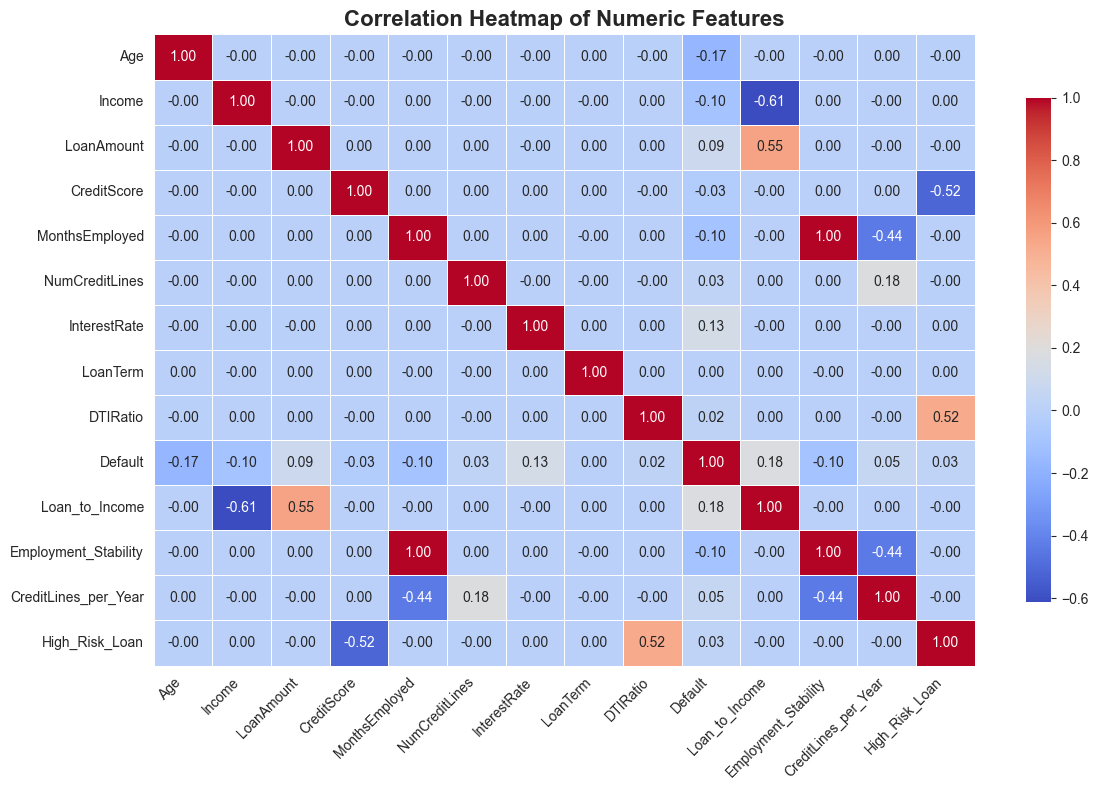

Default                 1.000000
Loan_to_Income          0.178963
InterestRate            0.131273
LoanAmount              0.086659
CreditLines_per_Year    0.054965
NumCreditLines          0.028330
High_Risk_Loan          0.025833
DTIRatio                0.019236
LoanTerm                0.000545
CreditScore            -0.034166
Employment_Stability   -0.097374
MonthsEmployed         -0.097374
Income                 -0.099119
Age                    -0.167783
Name: Default, dtype: float64

In [22]:
corr_matrix = df.corr(numeric_only=True)

plt.figure(figsize=(12,8))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='coolwarm',
    fmt='.2f',
    linewidths=0.5,
    cbar_kws={'shrink': 0.8}
)
plt.title('Correlation Heatmap of Numeric Features', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Correlation with the target
corr_with_target = corr_matrix['Default'].sort_values(ascending=False)
corr_with_target


### 5- (LoanAmount , CreditScore) vs Default Status

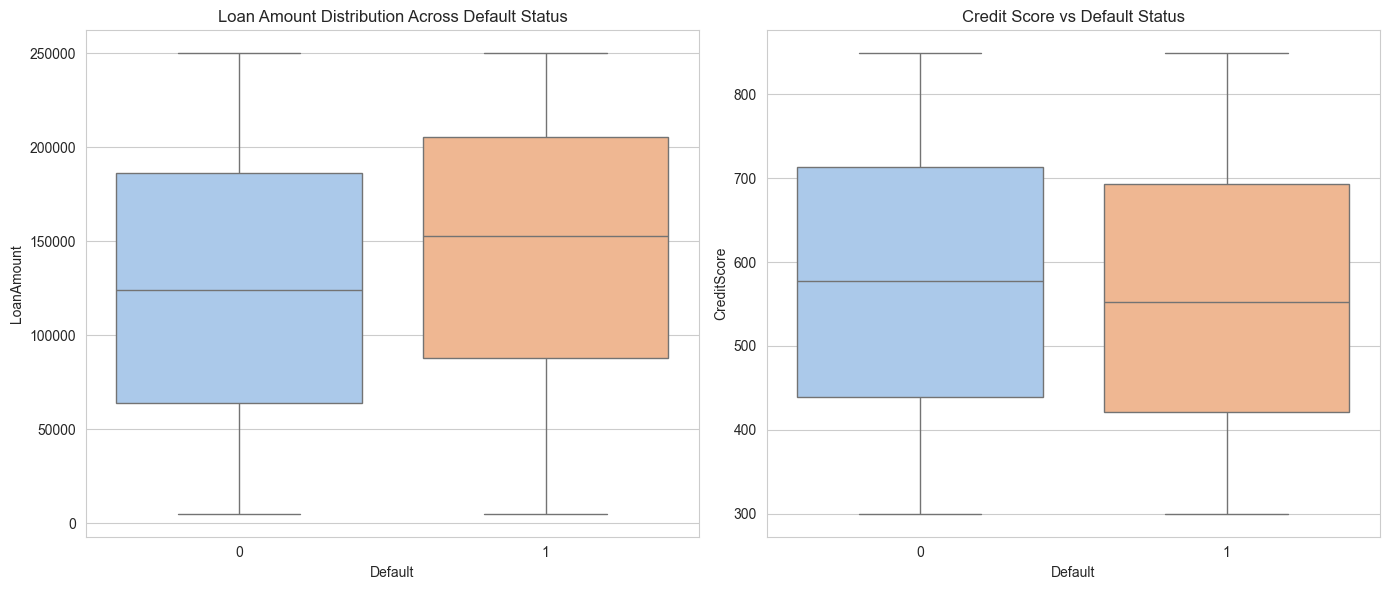

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: LoanAmount vs. Default
sns.boxplot(data=df, x='Default', y='LoanAmount', ax=axes[0], palette='pastel')
axes[0].set_title("Loan Amount Distribution Across Default Status")

# Plot 2: CreditScore vs. Default
sns.boxplot(data=df, x='Default', y='CreditScore', ax=axes[1], palette='pastel')
axes[1].set_title("Credit Score vs Default Status")

# Adjust layout and display
plt.tight_layout()
plt.show()

### 6- Loan Purpose vs Default Rate

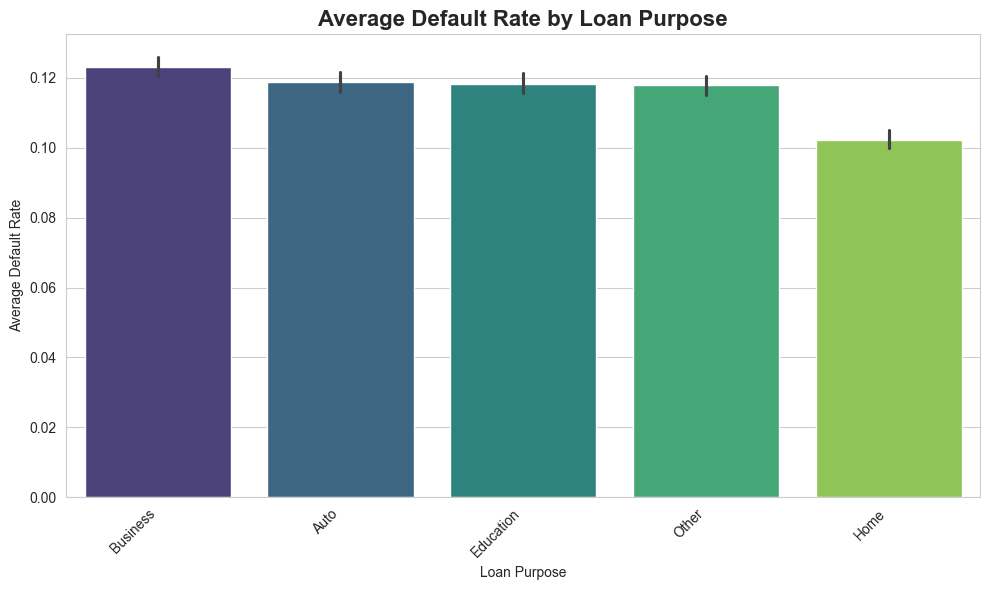

In [24]:
plt.figure(figsize=(10,6))
order = df.groupby('LoanPurpose')['Default'].mean().sort_values(ascending=False).index

sns.barplot(
    data=df,
    x='LoanPurpose',
    y='Default',
    order=order,
    estimator='mean',
    palette='viridis'
)

plt.title("Average Default Rate by Loan Purpose", fontsize=16, fontweight='bold')
plt.xlabel("Loan Purpose")
plt.ylabel("Average Default Rate")
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


### 7- (DTIRatio Distribution, Employment Stability)  by Default

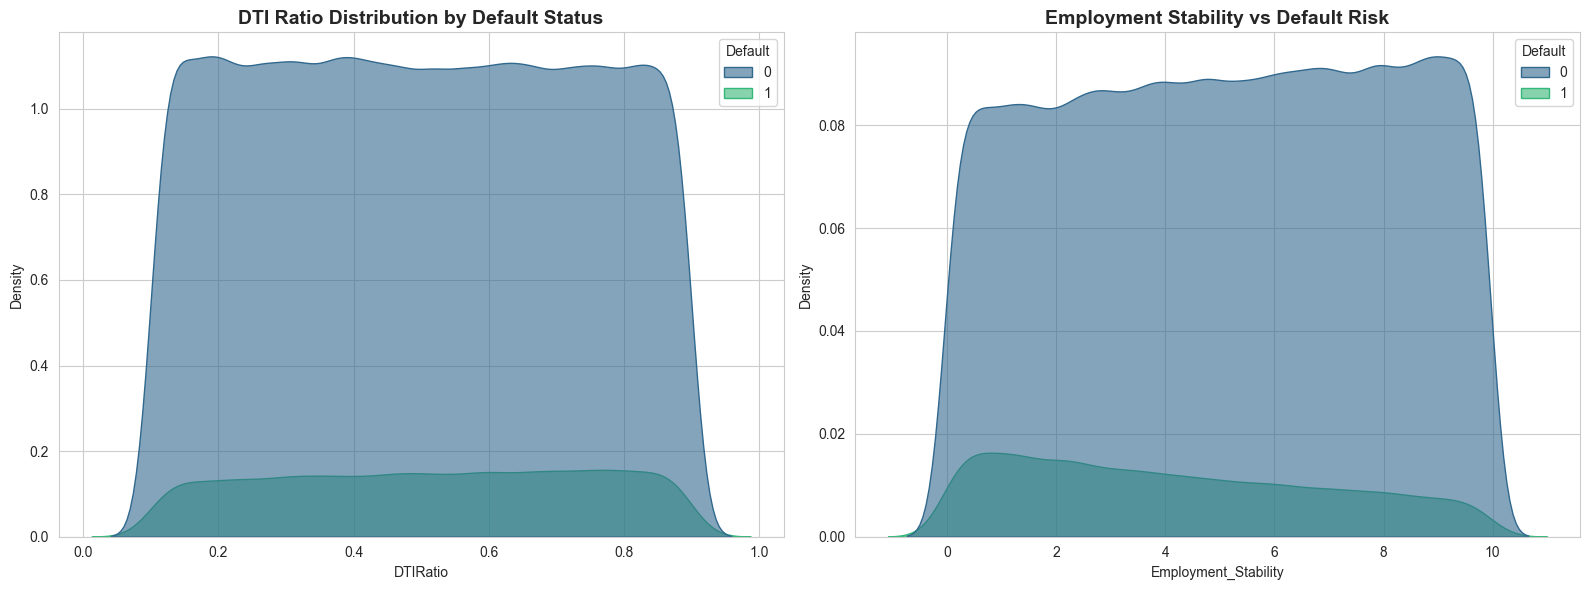

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for ax, col, title in zip(
    axes,
    ['DTIRatio', 'Employment_Stability'],
    ["DTI Ratio Distribution by Default Status",
     "Employment Stability vs Default Risk"]
):
    sns.kdeplot(
        data=df, x=col, hue='Default',
        fill=True, alpha=0.6, palette='viridis', ax=ax
    )
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel(col)

plt.tight_layout()
plt.show()


## Summary of Step: Exploratory Data Analysis (EDA)

In this step, we explored the loan dataset to understand feature distributions, relationships with the target, and correlations among variables. This provides insights for model building and preprocessing. Visualizations used include histograms, count plots, pie charts, boxplots, KDE plots, and a correlation heatmap.

**Key Insights:**

1. **Target Variable (Default):**  
   - Imbalanced: 88.4% No Default, 11.6% Default.  
   - Imbalance should be considered during model training.

2. **Numeric Features:**  
   - **CreditScore:** Lower median for defaulters → strong predictor of risk.  
   - **LoanAmount:** Slightly higher for defaulters → marginally increased risk.  
   - **DTIRatio:** Overlapping distributions → weak independent predictor.  
   - **Employment Stability:** Defaulters tend to have lower values → less stable employment increases risk.  

3. **Correlation Insights:**  
   - **CreditLines_per_Year** negatively correlated with Default → fewer new credit lines per year, lower risk.  
   - **Age** negatively correlated → younger borrowers default more.  
   - **CreditScore** negatively correlated → lower scores, higher default risk.  
   - Income and Loan_to_Income ratio strongly correlated (mathematical relation).  
   - CreditScore positively correlated with MonthsEmployed → stable employment often leads to better credit.

4. **Categorical Features:**  
   - Balanced distributions across categories; no single category dominates.  
   - **Loan Purpose:** Business and Auto loans have highest default rates; Home loans have lowest.

5. **Engineered Features Considered:**  
   - Features like `High_Risk_Loan`, `Loan_to_Income`, and `CreditLines_per_Year` were included in the analysis to capture additional predictive information.

**Conclusion:**  
EDA confirms which features are likely to be most predictive and highlights the imbalanced target, guiding preprocessing and model selection.


## 5- Step: Preprocessing & Encoding 

- In this step we prepare the dataset for machine learning by converting all features into numeric form and standardizing numeric values. We build and save transformation objects (scalers, encoders, column transformer) as variables so they can be reused later inside a final pipeline after model selection.



### 1- Define features and target

In [ ]:
numeric_cols = [
    'Age','Income','LoanAmount','CreditScore','MonthsEmployed',
    'NumCreditLines','InterestRate','LoanTerm','DTIRatio',
    'Loan_to_Income','Employment_Stability','CreditLines_per_Year','High_Risk_Loan'
]

categorical_cols = [
    'Education','EmploymentType','MaritalStatus',
    'HasMortgage','HasDependents','LoanPurpose','HasCoSigner'
]

target_col = 'Default'

X = df.drop(columns=[target_col])
y = df[target_col]


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)


X_train shape: (178742, 20)
X_test shape: (76605, 20)


### 2- Feature engineering saving for pipeline

In [ ]:
class FeatureEngineer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        # Engineered features
        X['Loan_to_Income'] = X['LoanAmount'] / X['Income']
        X['Employment_Stability'] = X['MonthsEmployed'] / 12
        X['CreditLines_per_Year'] = X['NumCreditLines'] / (X['Employment_Stability'] + 0.1)
        X['High_Risk_Loan'] = ((X['DTIRatio'] > 0.6) | (X['CreditScore'] < 500)).astype(int)
        return X


### 3- Define preprocessing pipelines

In [28]:
# Numeric transformer: impute missing values + scale
num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical transformer: one-hot encode
cat_transformer = Pipeline([
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

# Combine numeric + categorical transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, numeric_cols),
        ('cat', cat_transformer, categorical_cols)
    ],
    remainder='drop',  # drop any other columns
    verbose_feature_names_out=False
)


## 🔧  Data Preprocessing (Splitting, Encoding, and Scaling)

In this step, we prepare the dataset for modeling by applying essential preprocessing techniques:

### ✔️ Key Actions Performed
- **Separated features and target variable** (`Default`).
- **Stratified train–test split** to preserve the imbalanced target distribution.
- **Defined preprocessing pipelines**:
  - **Numeric pipeline:** Median imputation + Standard Scaling.
  - **Categorical pipeline:** One-Hot Encoding with unseen-category handling.
- **Combined pipelines using `ColumnTransformer`**, creating a reusable and clean preprocessing structure.
- **Fitted the preprocessor only on the training data**, then transformed both training and testing sets.

This ensures consistent, leakage-free preprocessing and prepares the data for the modeling phase.


## 6- Step: Machine Learning - Classification Models

In this step, we will train multiple classification models to predict loan default (`Default` column).  
We will evaluate each model using appropriate metrics to select the best-performing one.  


### 1- Classification Models

In [ ]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=500),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, n_jobs=-1),
    'Naive Bayes': GaussianNB(),
    'XGBoost': XGBClassifier(
        tree_method='hist',          #  use CPU mode instead of gpu_hist
        predictor='cpu_predictor',   #  ensure CPU prediction
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    )
}

### 2- Evaluate Models

In [36]:
results = []

for name, model in models.items():
    # Build pipeline for this model

    pipe = ImbPipeline([
    ('feature_engineer', FeatureEngineer()), # Step 1: Create new columns
    ('preprocess', preprocessor),            # Step 2: Clean & Scale (all cols)
    ('model', model)                         # Step 3: Train Model
    ])

    
    # Fit on training data
    pipe.fit(X_train, y_train)
    
    # Predict
    y_pred = pipe.predict(X_test)
    y_prob = pipe.predict_proba(X_test)[:, 1]  # for ROC-AUC
    
    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_prob)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)
    
    # Save results and pipeline
    results.append([name, acc, prec, rec, f1, roc, specificity, sensitivity, pipe])

# Save DataFrame with metrics and pipelines
import pandas as pd
results_df = pd.DataFrame(results, columns=[
    'Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score',
    'ROC-AUC', 'Specificity', 'Sensitivity', 'Pipeline'
])

# Display sorted by Accuracy
display(results_df.sort_values(by='Accuracy', ascending=False))

,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC,Specificity,Sensitivity,Pipeline
0,Logistic Regression,0.886979,0.619960,0.069132,0.124393,0.762611,0.994432,0.069132,"(FeatureEngineer(), ColumnTransformer(transfor..."
2,Random Forest,0.885882,0.629195,0.042154,0.079014,0.734991,0.996736,0.042154,"(FeatureEngineer(), ColumnTransformer(transfor..."
4,XGBoost,0.884759,0.523481,0.085207,0.146558,0.742209,0.989809,0.085207,"(FeatureEngineer(), ColumnTransformer(transfor..."
3,Naive Bayes,0.861145,0.343744,0.215265,0.264740,0.739792,0.946004,0.215265,"(FeatureEngineer(), ColumnTransformer(transfor..."
1,Decision Tree,0.804386,0.203871,0.235612,0.218595,0.557363,0.879115,0.235612,"(FeatureEngineer(), ColumnTransformer(transfor..."


### 3- Accuracy Comparison

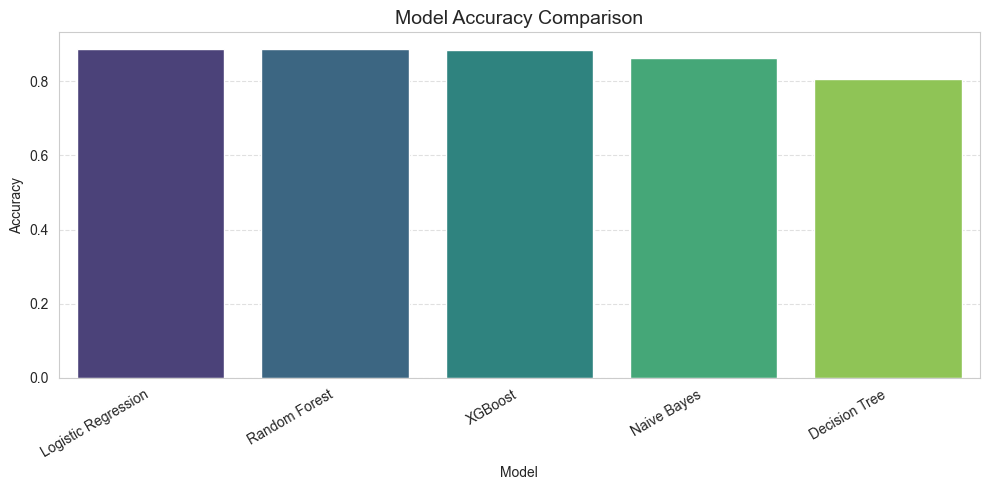

In [ ]:
results_df_sorted = results_df.sort_values(by='Accuracy', ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(data=results_df_sorted, x='Model', y='Accuracy', palette='viridis')
plt.title('Model Accuracy Comparison', fontsize=14)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.xticks(rotation=30, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


### 4- Heatmap of Metrics

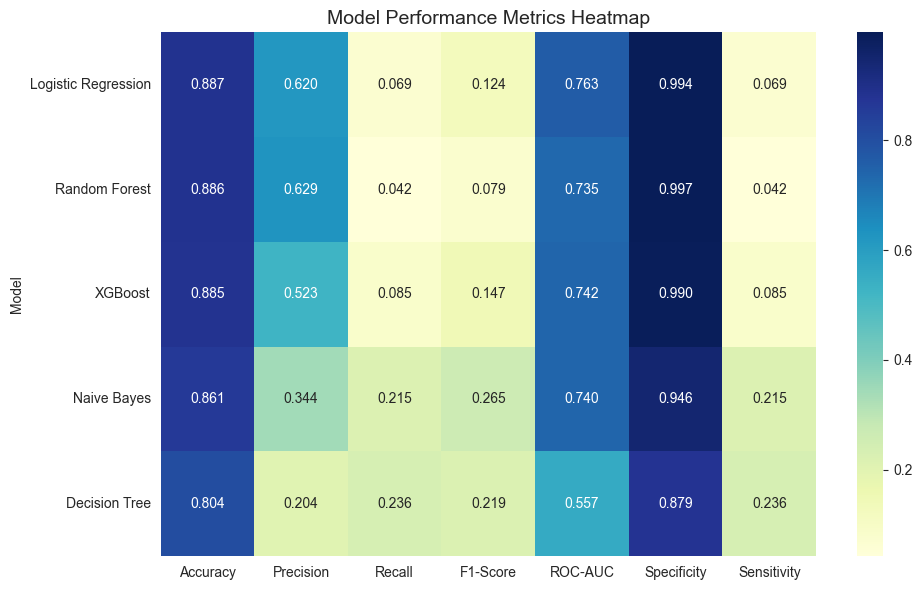

In [32]:
metrics_cols = ['Accuracy','Precision','Recall','F1-Score','ROC-AUC','Specificity','Sensitivity']

plt.figure(figsize=(10,6))
sns.heatmap(results_df_sorted.set_index('Model')[metrics_cols], annot=True, cmap='YlGnBu', fmt=".3f", cbar=True)
plt.title('Model Performance Metrics Heatmap', fontsize=14)
plt.tight_layout()
plt.show()


### 5- ROC Curve Comparison

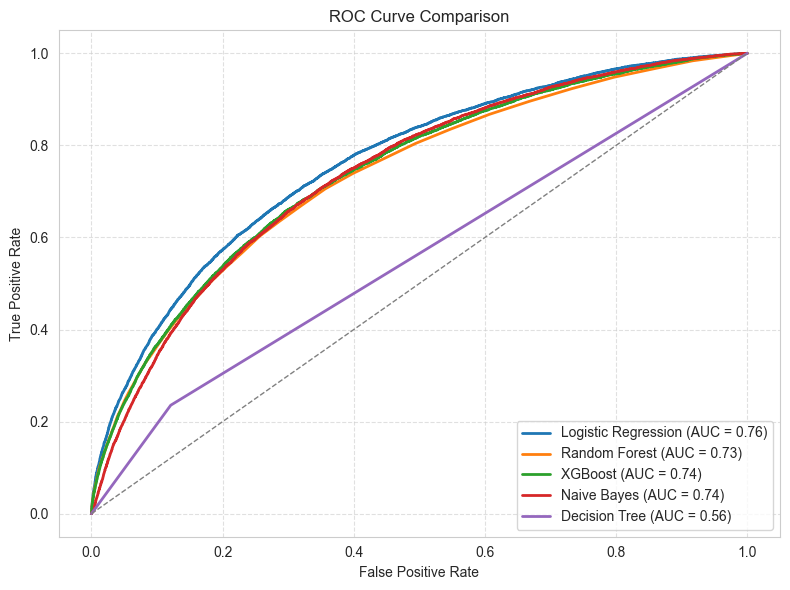

In [33]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(8,6))
for name, row in results_df_sorted.iterrows():
    model_pipeline = row['Pipeline']
    # Only for models with predict_proba
    if hasattr(model_pipeline.named_steps['model'], "predict_proba"):
        y_prob = model_pipeline.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{row["Model"]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


### 6- Save the best model pipeline

In [34]:
# 1. Dynamically select the best model based on a specific metric (e.g., ROC-AUC)
# We sort the results dataframe and pick the top one.
best_row = results_df.sort_values(by='ROC-AUC', ascending=False).iloc[0]

best_model_name = best_row['Model']
best_score = best_row['ROC-AUC']

print(f"🏆 The best model is '{best_model_name}' with ROC-AUC: {best_score:.4f}")

# 2. Extract the ALREADY FITTED pipeline object from the DataFrame
# (No need to redefine or refit if you want the exact model you just tested)
best_pipeline = best_row['Pipeline']

# 3. Save the pipeline to disk
file_name = f'best_model_{best_model_name.replace(" ", "_")}.joblib'
joblib.dump(best_pipeline, file_name)

print(f"✅ Successfully saved the pipeline to '{file_name}'")

🏆 The best model is 'Logistic Regression' with ROC-AUC: 0.7626
✅ Successfully saved the pipeline to 'best_model_Logistic_Regression.joblib'


# 🏆 Model Evaluation & Pipeline Summary

## 1. Workflow
* **Data Split:** 70% training / 30% testing with `stratify=y`.
* **Feature Engineering:** Added `Loan_to_Income`, `Employment_Stability`, `CreditLines_per_Year`, `High_Risk_Loan` via a custom `FeatureEngineer()` step in the pipeline.
* **Preprocessing:** `ColumnTransformer` with:
  - Median imputation + scaling for numeric features
  - One-Hot Encoding + scaling for categorical features
* **Modeling:** Evaluated five classifiers: Logistic Regression, Random Forest, XGBoost, Naive Bayes, Decision Tree.
* **Pipeline:** Each model trained inside an `ImbPipeline` with feature engineering + preprocessing.

## 2. Evaluation Metrics
* Metrics calculated: Accuracy, Precision, Recall, F1-Score, ROC-AUC, Specificity, Sensitivity.
* Models compared using the same transformed test data.

## 3. Results Overview
| Model | Accuracy | Precision | Recall | F1-Score | ROC-AUC |
| :--- | :--- | :--- | :--- | :--- | :--- |
| Logistic Regression | **0.8870** | 0.6200 | 0.0691 | 0.1244 | **0.7626** |
| Random Forest | 0.8859 | 0.6292 | 0.0422 | 0.0790 | 0.7350 |
| XGBoost | 0.8848 | 0.5235 | 0.0852 | 0.1466 | 0.7422 |
| Naive Bayes | 0.8611 | 0.3437 | 0.2153 | 0.2647 | 0.7398 |
| Decision Tree | 0.8044 | 0.2039 | 0.2356 | 0.2186 | 0.5574 |

## 4. Key Takeaways
* **Best Overall (ROC-AUC):** Logistic Regression
* **High Recall Alternative:** Naive Bayes for detecting more defaulters.
* **Full Pipeline Saved:** Includes feature engineering, preprocessing, and trained model for easy future predictions.

**File Saved:** `best_model_pipeline.joblib`
